# Import Libraries

In [1]:
from visualizations import *
import numpy as np
import pandas as pd
import warnings
from math import tau
from scipy.integrate import quad
warnings.filterwarnings('ignore')

## Load data

In [2]:
data = np.loadtxt("./../DATA/digits2k_pixels.data.gz", ndmin=2)/255.0
data.shape = (data.shape[0], int(np.sqrt(data.shape[1])), int(np.sqrt(data.shape[1])))
labels = np.loadtxt("./../DATA/digits2k_pixels.labels.gz", dtype='int')

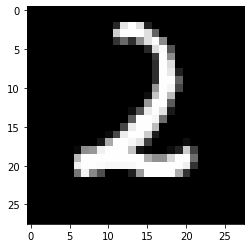

In [24]:
i = 122
plt.imshow(data[i,:,:], cmap=plt.get_cmap("gray"))

## Function to transform to binary matrix

In [25]:
def onlyBlackWhite(array, threshold = 0.01):
    result = array.copy()
    for i in range(len(result)):
        for j in range(len(result[0])):
            if (result[i,j] < threshold):
                result[i,j] = 0
            else:
                result[i,j] = 1
    return result

In [26]:
copied = onlyBlackWhite(data[i,:,:])

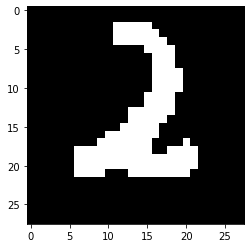

In [27]:
plt.imshow(copied, cmap=plt.get_cmap("gray"))

## Getting contour points of image

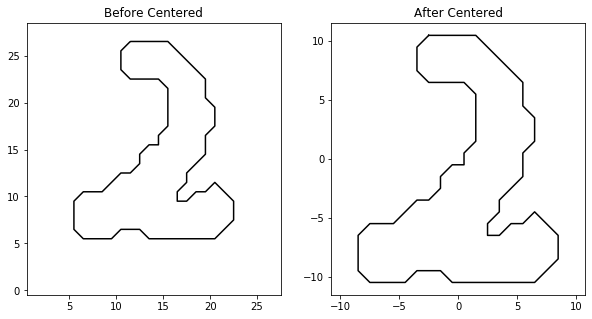

In [28]:
time_table, x_table, y_table = create_close_loop(copied)

# Finding Fourier coefficients

## $c_{n}=\frac{1}{2\pi}\int_{0}^{2\pi}f(t)e^{-jnt}dt$
## $f(t)=\sum_{n=-\infty}^{\infty}c_{n}e^{-jnt}$

Of course to get $f(t)$ we first need to somehow know $f(t)$. We know that $f$ is a function of $t\in[0,2\pi]$(treated as time) and returns a complex number corresponding to a point location. To get $c_{n}$(Fourier coefficients), we will aproximate $f$ values for each $n$ with the function below.  
Of course $tau=2\pi$

In [29]:
time_table = np.linspace(0, tau, len(x_table)) # arguments for aproximated f function

In [30]:
def f(t, time_table, x_table, y_table):
    return interp(t, time_table, x_table) + 1j*interp(t, time_table, y_table)

### Coefficients finding function

Since $f(t)$ results in $z = a+bj$  
$c_{n}=\frac{1}{2\pi}\int_{0}^{2\pi}f(t)e^{-jnt}dt=\frac{1}{2\pi}\int_{0}^{2\pi}ae^{-jnt}+bjae^{-jnt}dt=$

In [31]:
def coef_list(time_table, x_table, y_table, order=10):
    """
    Counting c_n coefficients of Fourier series, of function aproximated by points (time_table, x_table + j*y_table)
    of order of magnitude = order
    """
    coef_list = []
    for n in range(-order, order+1):
        real_coef = quad(lambda t: np.real(f(t, time_table, x_table, y_table) * np.exp(-n*1j*t)), 0, tau, limit=100, full_output=1)[0]/tau
        imag_coef = quad(lambda t: np.imag(f(t, time_table, x_table, y_table) * np.exp(-n*1j*t)), 0, tau, limit=100, full_output=1)[0]/tau
        coef_list.append([real_coef, imag_coef])
    return np.array(coef_list)

In [32]:
coef = coef_list(time_table, x_table, y_table)
print(coef)

[[ 6.16648447e-02 -2.97562156e-02]
 [-7.64972738e-02  2.12918768e-01]
 [ 3.90975556e-02 -1.06562404e-03]
 [-7.27181354e-02 -5.71940577e-02]
 [-4.39588183e-01  4.76254828e-01]
 [ 1.79525195e-01 -2.02101811e-01]
 [-7.12706919e-01 -2.03364286e-02]
 [-1.46522385e+00  1.14546330e+00]
 [-2.43709611e-01 -5.00714837e-01]
 [-4.42835517e-02  7.49167394e+00]
 [ 7.74025141e-01 -1.80136938e+00]
 [ 4.43745665e-01  2.26284790e+00]
 [-1.36833545e-01  1.98655304e+00]
 [-8.05197615e-01 -5.93673403e-01]
 [-3.68341361e-01 -1.12138793e-01]
 [-2.07263653e-02  8.45511321e-02]
 [ 2.03409721e-01 -1.48795992e-01]
 [-2.30817514e-02 -1.59286328e-01]
 [ 6.50949445e-02  2.59649915e-02]
 [ 8.99393375e-02  1.13518008e-01]
 [-1.79360954e-02 -7.04723905e-02]]


These are counted coefficients for shape of imported image, which will be further used to compare images. Fortunately Fourier Series can be treated as simmilar whenever their coefficients are close to each other.

## Visualize

### Calculate points to plot by aproximated Fourier series

In [33]:
space = np.linspace(0, tau, 300)
x_DFT = [DFT(t, coef)[0] for t in space]
y_DFT = [DFT(t, coef)[1] for t in space]

### Draw contour(black) and aproximated Fourier line(red)

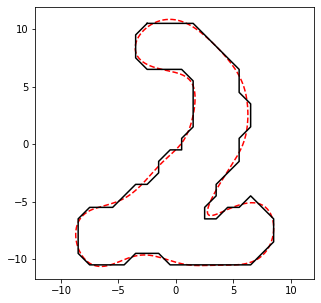

In [34]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_DFT, y_DFT, 'r--')
ax.plot(x_table, y_table, 'k-')
ax.set_aspect('equal', 'datalim')
xmin, xmax = xlim()
ymin, ymax = ylim()

### Create animation

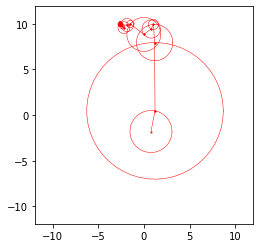

In [35]:
order = 10
anim = visualize(x_DFT, y_DFT, coef, order, space, [xmin, xmax, ymin, ymax])
Writer = animation.writers['html']
writer = Writer(fps=75)
anim.save('dwa.html', writer=writer, dpi=150)